# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-05-23 ~ 2024-05-28

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import requests
import json
import pandas as pd

from dotenv import load_dotenv
import os

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

import warnings
warnings.filterwarnings('ignore')


## 기타 설정

In [2]:
# 데이터 프레임 열 전부 표시
pd.set_option('display.max_columns', None)

In [3]:
load_dotenv()
myKEY = os.environ.get('PUBLIC_DATA_API_KEY')

# 2. API 데이터 수집

## A. [환경부 국립환경과학원_골프장 농약사용량 DB](https://www.data.go.kr/data/15000937/openapi.do)

In [4]:
# 2020년 전국 데이터
golf_url = 'http://apis.data.go.kr/1480523/SgisGp/getSgisGpList1' #API 호출 URL
golf_params = {'serviceKey' : myKEY, 'pageNo' : '1', 'numOfRows' : '1000', 'resultType' : 'JSON', 'search_year': '2018'} #parameter 지정

golf_response = requests.get(golf_url, params=golf_params) #API 호출 응답 결과 저장
#golf_response.content

In [5]:
golf_result = json.loads(golf_response.content) #응답을 json 형식으로 변환
#golf_result['getSgisGpList']['header']

In [6]:
golf = pd.DataFrame(golf_result['getSgisGpList']['item']) #item 항목을 data frame으로 저장 - 전국 데이터
golf.sample()

,SPOT_STD_CODE,YEAR,GOLFCLUB_NAME,ADDRESS,HOLE_CNT,SIDO,REG_YEAR,GOLF_TYPE_NAME,TOTAL_GROUND,PES_GROUND,NONE_GROUND,SPRAY_SUPPLY,REAL_SUPPLY,HA_REAL,HA_SPRAY,THA_REAL,THA_SPRAY
463,48170G040100001,2018,진주CC,경상남도 진주시 진성면 상촌리 산1,18,경상남도,1996,회원제,1068481.0,416524.0,651957.0,824.6998,278.9422,6.696905820552958,19.79957457433425,2.6106425851278594,7.718432054477337


In [7]:
new_columns = {
    'SPOT_STD_CODE': '지점표준코드',
    'SIDO': '시도',
    'GOLFCLUB_NAME': '골프장명',
    'GOLF_TYPE_NAME': '골프장 형태',
    'ADDRESS': '소재지',
    'HOLE_CNT': '홀수',
    'REG_YEAR': '개장년도',
    'YEAR': '입력년도',
    'PES_GROUND': '농약사용면적(m2)',
    'TOTAL_GROUND': '면적총계(m2)',
    'NONE_GROUND': '농약미사용면적(m2)',
    'SPRAY_SUPPLY': '총사용량_실물량(kg)',
    'REAL_SUPPLY': '총사용량_성분량(kg)',
    'THA_SPRAY': '전체면적대비_ha_실물량(kg)',
    'THA_REAL': '전체면적대비_ha_성분량(kg)',
    'HA_SPRAY': '농약사용_ha_실물량(kg)',
    'HA_REAL': '농약사용_ha_성분량(kg)'
}

In [8]:
# column 이름 변경
golf.rename(columns=new_columns, inplace=True)
golf.sample()

,지점표준코드,입력년도,골프장명,소재지,홀수,시도,개장년도,골프장 형태,면적총계(m2),농약사용면적(m2),농약미사용면적(m2),총사용량_실물량(kg),총사용량_성분량(kg),농약사용_ha_성분량(kg),농약사용_ha_실물량(kg),전체면적대비_ha_성분량(kg),전체면적대비_ha_실물량(kg)
36,41220G040300001,2018,만포대체력단련장,경기도 평택시 포승읍 원정리 산1280,18,경기도,1999,체력단련장,839208.0,780023.0,59185.0,627.6,179.2115,2.297515586078872,8.045916594767077,2.135483694149722,7.478479709440331


In [9]:
# 시군구 추출 함수 - 주소를 공백을 기준으로 나눠 시군구 추출
def ExtractSigungoo(address):
    parts = address.split()
    if len(parts) > 1: #주소가 둘 이상으로 쪼개질 경우
        return parts[1]
    return None

# 시군구 컬럼 추가
golf['시군구'] = golf['소재지'].apply(ExtractSigungoo)

# 시도 컬럼 바로 옆에 시군구 컬럼 배치
columns = list(golf.columns)
sido_index = columns.index('시도') #'시도' column의 index 추출
columns.insert(sido_index + 1, columns.pop(columns.index('시군구'))) #바로 옆에 추가하고 기존 column을 삭제
golf = golf[columns]

In [10]:
golf.sample()

,지점표준코드,입력년도,골프장명,소재지,홀수,시도,시군구,개장년도,골프장 형태,면적총계(m2),농약사용면적(m2),농약미사용면적(m2),총사용량_실물량(kg),총사용량_성분량(kg),농약사용_ha_성분량(kg),농약사용_ha_실물량(kg),전체면적대비_ha_성분량(kg),전체면적대비_ha_실물량(kg)
394,50130G040200008,2018,핀크스GC,제주특별자치도 서귀포시 안덕면 상천리 62-3,9,제주특별자치도,서귀포시,1999,대중제,370327.0,248309.0,122018.0,1076.76,228.6012,9.20631954540512,43.36371214897567,6.172955253060134,29.075924790793003


In [11]:
# 시도별 소재지 주소 고유값 개수 - 시도별 골프장 수
unique_addresses = golf.groupby('시도')['소재지'].nunique().reset_index()
unique_addresses

,시도,소재지
0,강원도,57
1,경기도,145
2,경상남도,38
3,경상북도,49
4,광주광역시,4
5,대구광역시,4
6,대전광역시,4
7,부산광역시,12
8,서울특별시,1
9,세종특별자치시,2


In [12]:
golf[golf['시도']=='강원도']['시군구'].unique()

array(['횡성군', '원주시', '춘천시', '태백시', '고성군', '정선군', '홍천군', '삼척시', '강릉시',
       '속초시', '평창군', '철원군', '동해시', '영월군', '양양군'], dtype=object)

In [13]:
# 데이터 저장
golf[golf['시도']=='강원도'].to_csv('../data/golf_Gangwon_2018.csv', index=False, encoding='utf-8-sig')

## B. [강원특별자치도_강수량 통계](https://www.data.go.kr/data/3081221/fileData.do)

In [14]:
rain_2020 = pd.read_csv('../data/강수량_20240526105254.csv', encoding='cp949', header=1)
rain_2019 = pd.read_csv('../data/강수량_20240526105308.csv', encoding='cp949', header=1)
rain_2018 = pd.read_csv('../data/강수량_20240526105317.csv', encoding='cp949', header=1)

In [15]:
rain_2020.head()

,시군별,전체,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,전체,1590.3,91.5,53.7,28.0,33.3,127.0,121.2,269.1,516.9,302.6,7.0,36.4,3.4
1,춘천시,1550.9,80.0,54.2,13.8,14.4,118.3,75.8,174.3,773.7,157.2,0.1,84.2,4.9
2,원주시,1317.0,58.7,65.5,21.2,15.7,80.0,49.6,204.7,634.0,148.9,11.3,23.6,3.8
3,강릉시,1812.9,107.5,77.5,47.1,65.6,95.5,270.4,375.9,150.4,613.8,0.6,7.7,0.9
4,동해시,1322.4,97.9,73.7,48.3,50.9,90.3,120.4,346.1,171.9,304.0,5.1,11.5,2.3


In [16]:
rain_2019.head()

,시군별,전체,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,전체,1048.3,3.4,21.3,40.7,56.9,17.3,103.7,200.0,172.1,207.0,148.5,68.0,9.6
1,춘천시,923.2,1.3,29.0,38.7,49.4,27.1,76.4,238.6,192.3,142.6,50.3,63.1,14.4
2,원주시,771.9,0.7,25.4,42.8,45.7,10.4,67.9,137.1,142.4,171.1,40.3,74.0,14.1
3,강릉시,1670.5,16.6,17.7,49.6,85.5,4.5,132.2,220.8,264.5,233.3,536.0,104.7,5.1
4,동해시,1532.8,14.3,15.4,51.5,102.6,3.3,125.4,191.4,149.9,255.6,512.5,102.1,8.8


In [17]:
rain_2018.head()

,시군별,전체,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,전체,1502.1,5.3,35.4,58.7,133.4,170.6,78.4,223.2,399.9,124.9,173.0,80.8,18.6
1,춘천시,1401.5,5.9,36.5,32.8,139.5,201.9,104.1,213.6,389.5,69.9,127.5,63.5,16.8
2,원주시,1229.2,4.4,27.4,53.6,112.6,211.3,131.8,122.5,258.2,147.6,89.5,45.0,25.3
3,강릉시,1599.4,2.5,52.0,94.0,151.4,162.9,38.6,195.5,419.1,161.2,248.0,51.3,22.9
4,동해시,1436.5,4.4,53.4,95.4,131.8,63.6,36.6,286.0,219.8,205.6,273.2,44.5,22.2


## C. [환경부 국립환경과학원_수질 DB](https://www.data.go.kr/data/15081073/openapi.do)

### 시도별 수질측정망 지점

In [39]:
code_df = pd.read_excel('../API documents/국립환경과학원_openAPI_활용가이드_수질DB/물환경 수질측정망 운영결과 DB_물환경_코드_코드명.xlsx', header=1)
code_df

,구분,지점코드,지점명,조사기관,주소,대권역,중권역
0,하천수,1001A05,송천1,원주지방환경청,강원도 평창군 대관령면 용산리(용산교),한강,남한강상류
1,하천수,1001A10,송천4,원주지방환경청,강원도 정선군 여량면 유천리(송천교),한강,남한강상류
2,하천수,1001A15,골지천2,한국수자원공사,강원도 태백시 하사미동 290-1(하사미교),한강,남한강상류
3,하천수,1001A20,번천,한국수자원공사,강원도 삼척시 하장면 숙암리 90-4,한강,남한강상류
4,하천수,1001A25,골지천4,원주지방환경청,강원도 정선군 여량면 여량리(여량1교),한강,남한강상류
...,...,...,...,...,...,...,...
2213,하천수,5101A05,탐진강1(탐진A1),영산강물환경연구소,전라남도 장흥군 유치면 운월리(운월교),영산강ㆍ섬진강,탐진강
2214,하천수,5101A15,유치천1(탐진A2),영산강물환경연구소,전라남도 영암군 금정면 연소리(한대교),영산강ㆍ섬진강,탐진강
2215,하천수,5101A25,옴천천2(탐진A3),영산강물환경연구소,전라남도 강진군 옴천면 봉림리(봉림교),영산강ㆍ섬진강,탐진강
2216,하천수,5101A45,금강천1(탐진B1),영산강물환경연구소,전라남도 강진군 병영면 삭양리(삭양교),영산강ㆍ섬진강,탐진강


In [40]:
# 주소 컬럼의 데이터를 공백을 기준으로 분리하여 시도, 시군구 추출
code_df['시도'] = code_df['주소'].apply(lambda x: x.split()[0])
code_df['시군구'] = code_df['주소'].apply(lambda x: x.split()[1])

print(code_df['시도'].unique())
print()
print(code_df['시군구'].unique())

['강원도' '충청북도' '경기도' '서울특별시' '인천광역시' '충청남도' '인천광역시시' '경상북도' '경북' '대구광역시'
 '대구광역시시' '경상남도' '전라북도' '부산광역시' '울산광역시' '울산광역시시' '부산광역시시' '대전광역시' '대전광역시시'
 '세종특별자치시' '전라남도' '광주' '광주광역시' '제주특별자치도']

['평창군' '정선군' '태백시' '삼척시' '영월군' '횡성군' '원주시' '단양군' '제천시' '충주시' '청주시' '괴산군'
 '보은군' '음성군' '홍천군' '안성시' '이천시' '여주시' '양평군' '용인시' '화천군' '양구군' '춘천시' '인제군'
 '가평군' '남양주시' '광주시' '강동구' '성남시' '강남구' '성동구' '의정부시' '노원구' '성북구' '동대문구' '중구'
 '용산구' '영등포구' '마포구' '군포시' '안양시' '구로구' '동작구' '양천구' '강서구' '고양시' '김포시' '계양구'
 '파주시' '연천군' '철원군' '포천시' '양주시' '동두천시' '하남시' '구리시' '송파구' '천안시' '평택시' '화성시'
 '오산시' '의왕시' '수원시' '아산시' '강화군' '서구' '시흥시' '남동구' '화성군' '안산시' '고성군' '양양군'
 '속초시' '강릉시' '동해시' '봉화군' '안동시' '영양군' '청송군' '예천군' '의성군' '영주시' '문경시' '상주시'
 '군위군' '구미시' '김천시' '칠곡군' '성주군' '달성군' '영천시' '경산시' '동구' '북구' '달서구' '수성구'
 '합천군' '고령군' '창녕군' '달성구' '거창군' '의령군' '함양군' '남원시' '산청군' '진주시' '사천시' '하동군'
 '함안군' '창원시' '밀양시' '김해시' '경주시' '청도군' '양산시' '사상구' '사하구' '포항시' '울주군' '포항'
 '남구' '금정구' '수영구' '기장군' '동래구' '해운대구광역시' '부산광역시진구' '울진군' '영덕군' '남해군' '거제시'
 '창원' 

In [41]:
sido_correction = {
    '서울특별시': '서울특별시',
    '인천광역시': '인천광역시',
    '인천광역시시': '인천광역시',
    '대구광역시': '대구광역시',
    '대구광역시시': '대구광역시',
    '부산광역시': '부산광역시',
    '부산광역시시': '부산광역시',
    '경기도': '경기도',
    '강원도': '강원도',
    '충청북도': '충청북도',
    '충청남도': '충청남도',
    '전라북도': '전라북도',
    '전라남도': '전라남도',
    '제주특별자치도': '제주특별자치도',
    '세종특별자치시': '세종특별자치시',
    '경상북도': '경상북도',
    '경북': '경상북도',
    '경상남도': '경상남도',
    '광주광역시': '광주광역시',
    '광주': '광주광역시',
    '울산광역시': '울산광역시',
    '울산광역시시': '울산광역시',
    '대전광역시': '대전광역시',
    '대전광역시시': '대전광역시'
}

In [42]:
# 오타 수정
code_df['시도'] = code_df['시도'].map(sido_correction)
code_df['시도'].unique()

array(['강원도', '충청북도', '경기도', '서울특별시', '인천광역시', '충청남도', '경상북도', '대구광역시',
       '경상남도', '전라북도', '부산광역시', '울산광역시', '대전광역시', '세종특별자치시', '전라남도',
       '광주광역시', '제주특별자치도'], dtype=object)

In [43]:
code_df[code_df['시도']=='강원도']['시군구'].unique()

array(['평창군', '정선군', '태백시', '삼척시', '영월군', '횡성군', '원주시', '홍천군', '화천군',
       '양구군', '춘천시', '인제군', '가평군', '파주시', '철원군', '고성군', '양양군', '속초시',
       '강릉시', '동해시'], dtype=object)

In [44]:
# 강원도 지점코드 추출
codes = code_df[code_df['시도']=='강원도']['지점코드'].unique()
codes_list = list(codes)
code_Gangwon = ','.join(codes_list)
code_Gangwon

'1001A05,1001A10,1001A15,1001A20,1001A25,1001A30,1001A35,1001A40,1001A45,1001A50,1001A55,1001A60,1001A65,1001A70,1001A75,1001A80,1001A85,1001B10,1002A10,1002A20,1002A30,1002A40,1002A50,1002A55,1002D10,1002D20,1002D30,1002D40,1002D50,1002D60,1003A05,1003A10,1003A15,1005A55,1005A60,1005D10,1005D20,1006A05,1006A10,1006A15,1006A20,1006A25,1006A30,1006A35,1006A40,1006A45,1006A50,1006A55,1006A60,1006A65,1006A70,1006A80,1006B10,1006B20,1006B30,1006D05,1006D10,1006D15,1006D20,1006D25,1006D30,1006D35,1006D40,1006D45,1006D50,1006D55,1006D60,1006E11,1009A10,1009B10,1009B20,1010A10,1010A30,1010A40,1010A50,1010B10,1010B20,1010B30,1010B40,1010B50,1010B60,1010D10,1010D20,1011A10,1011A20,1011A30,1011D10,1012A20,1012A30,1012A40,1012B10,1012B20,1012B30,1012B35,1012B40,1012D10,1012E11,1013A05,1013A10,1013A20,1013A40,1013A50,1013A60,1013B10,1013B20,1013B30,1013D10,1013D20,1013D30,1014A10,1014A20,1014A30,1014A70,1014D10,1014D20,1014D30,1014D40,1014D50,1014D60,1014D70,1014D80,1014E10,1019D10,1021D10,1022A05

### 물환경 수질측정망 운영결과 월평균 DB

In [213]:
water_qual_url = 'http://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringListMavg' #API 호출 URL
water_qual_params ={'serviceKey' : myKEY, 'pageNo' : '1', 'numOfRows' : '5000', 'resultType' : 'JSON', 'ptNoList' : code_Gangwon, 'wmyrList' : '2018'} #parameter 지정

water_qual_response = requests.get(water_qual_url, params=water_qual_params) #API 호출 응답 결과 저장
#print(water_qual_response.content)

In [214]:
water_qual_result = json.loads(water_qual_response.content) #응답을 json 형식으로 변환
#water_qual_result['getWaterMeasuringListMavg']['item']

In [215]:
water_qual = pd.DataFrame(water_qual_result['getWaterMeasuringListMavg']['item']) #item 항목을 data frame으로 저장
water_qual.sample()

,ROWNO,PTNM,PTNO,WMYR,WMOD,ITEMAMNT,ITEMTEMP,ITEMPH,ITEMDOC,ITEMBOD,ITEMCOD,ITEMSS,ITEMTCOLI,ITEMTN,ITEMTP,ITEMCD,ITEMCN,ITEMPB,ITEMCR6,ITEMAS,ITEMHG,ITEMCU,ITEMABS,ITEMPCB,ITEMOP,ITEMMN,ITEMTRANS,ITEMCLOA,ITEMZN,ITEMCR,ITEMFE,ITEMPHENOL,ITEMNHEX,ITEMEC,ITEMTCE,ITEMPCE,ITEMNO3N,ITEMNH3N,ITEMECOLI,ITEMPOP,ITEMDTN,ITEMDTP,ITEMFL,ITEMCOL,ITEMCCL4,ITEMDCM,ITEMBENZENE,ITEMCHCL3,ITEMTOC,ITEMDEHP,ITEMANTIMON,ITEMDIOX,ITEMHCHO,ITEMHCB,ITEMNI,ITEMBA,ITEMSE
1528,1529,인북천2,1011A30,2018,09,NaN,21.6,8.3,9.9,1.4,2.7,1.3,4900.0,1.934,0.011,0.00001,0.0,0.00014,0.0,0.00038,0.0,NaN,0.0,NaN,NaN,NaN,NaN,2.2,NaN,NaN,NaN,0.0,NaN,103.0,NaN,NaN,1.476,0.02,0.0,0.0,1.694,0.009,NaN,None,NaN,NaN,NaN,NaN,0.9,NaN,0.0,NaN,NaN,NaN,NaN,NaN,None


In [216]:
water_qual.columns

Index(['ROWNO', 'PTNM', 'PTNO', 'WMYR', 'WMOD', 'ITEMAMNT', 'ITEMTEMP',
       'ITEMPH', 'ITEMDOC', 'ITEMBOD', 'ITEMCOD', 'ITEMSS', 'ITEMTCOLI',
       'ITEMTN', 'ITEMTP', 'ITEMCD', 'ITEMCN', 'ITEMPB', 'ITEMCR6', 'ITEMAS',
       'ITEMHG', 'ITEMCU', 'ITEMABS', 'ITEMPCB', 'ITEMOP', 'ITEMMN',
       'ITEMTRANS', 'ITEMCLOA', 'ITEMZN', 'ITEMCR', 'ITEMFE', 'ITEMPHENOL',
       'ITEMNHEX', 'ITEMEC', 'ITEMTCE', 'ITEMPCE', 'ITEMNO3N', 'ITEMNH3N',
       'ITEMECOLI', 'ITEMPOP', 'ITEMDTN', 'ITEMDTP', 'ITEMFL', 'ITEMCOL',
       'ITEMCCL4', 'ITEMDCM', 'ITEMBENZENE', 'ITEMCHCL3', 'ITEMTOC',
       'ITEMDEHP', 'ITEMANTIMON', 'ITEMDIOX', 'ITEMHCHO', 'ITEMHCB', 'ITEMNI',
       'ITEMBA', 'ITEMSE'],
      dtype='object')

In [217]:
# 분석 대상 column만 추출
selected_columns = ['PTNM', 'PTNO', 'WMYR', 'WMOD', 'ITEMTCOLI']
water_qual = water_qual[selected_columns]
water_qual.sample()

,PTNM,PTNO,WMYR,WMOD,ITEMTCOLI
1434,월운저수지,1010D20,2018,05,NaN


In [218]:
new_columns = {
    'PTNO': '조사지점코드',
    'PTNM': '조사지점명',
    'WMYR': '측정년도',
    'WMOD': '측정월',
    'ITEMTCOLI': '측정값(총대장균군)'
}


In [219]:
# 컬럼 이름 변경
water_qual.rename(columns=new_columns, inplace=True)
water_qual.sample()

,조사지점명,조사지점코드,측정년도,측정월,측정값(총대장균군)
1190,의암댐,1013A40,2018,10,1018.0


In [220]:
water_qual[['측정값(총대장균군)']].describe()

,측정값(총대장균군)
count,1326.000000
mean,9030.554299
std,27761.958450
min,0.000000
25%,237.000000
50%,1295.000000
75%,7275.000000
max,752000.000000


In [221]:
# 결측치 수와 비율 계산
missing_count = water_qual.isnull().sum()
missing_ratio = round(missing_count / len(water_qual) * 100, 2)

# 결측치 수와 비율 출력
missing_info = pd.concat([missing_count, missing_ratio], axis=1, keys=['결측치 수', '결측치 비율 (%)'])
print(missing_info)

            결측치 수  결측치 비율 (%)
조사지점명           0        0.00
조사지점코드          0        0.00
측정년도            0        0.00
측정월             0        0.00
측정값(총대장균군)    284       17.64


In [222]:
# '조사지점코드'을 기준으로'측정월'을 바르게 정렬
water_qual = water_qual.groupby('조사지점코드').apply(lambda x: x.sort_values('측정월', ascending=True)).reset_index(drop=True)
water_qual

,조사지점명,조사지점코드,측정년도,측정월,측정값(총대장균군)
0,송천1,1001A05,2018,01,5700.0
1,송천1,1001A05,2018,03,3120.0
2,송천1,1001A05,2018,04,11500.0
3,송천1,1001A05,2018,05,7640.0
4,송천1,1001A05,2018,06,33200.0
...,...,...,...,...,...
1605,황지2,2001A30,2018,08,12700.0
1606,황지2,2001A30,2018,09,10600.0
1607,황지2,2001A30,2018,10,28400.0
1608,황지2,2001A30,2018,11,4100.0


In [223]:
# 결측치가 있는 행
na_values = water_qual[water_qual['측정값(총대장균군)'].isna()]
na_values

,조사지점명,조사지점코드,측정년도,측정월,측정값(총대장균군)
181,영월1,1001A85,2018,01,NaN
276,황둔저수지,1002D10,2018,04,NaN
277,황둔저수지,1002D10,2018,06,NaN
278,황둔저수지,1002D10,2018,09,NaN
279,황둔저수지,1002D10,2018,11,NaN
...,...,...,...,...,...
1511,옥계저수지,1302D55,2018,10,NaN
1572,초당저수지,1303D10,2018,03,NaN
1573,초당저수지,1303D10,2018,06,NaN
1574,초당저수지,1303D10,2018,08,NaN


In [224]:
# 결측치의 측정월 분포 계산
month_distribution = na_values['측정월'].value_counts().sort_index()
month_distribution

측정월
01     4
02     5
03    28
04    38
05    37
06    31
07    15
08    40
09    16
10    39
11    28
12     3
Name: count, dtype: int64

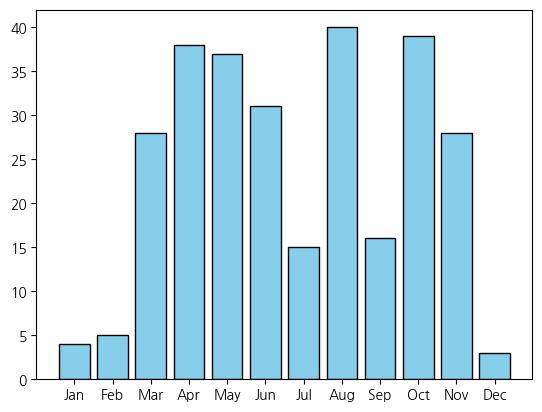

In [225]:
# 측정월을 1월부터 12월까지 정렬
months = list(range(0, 12))
month_counts = [month_distribution.get(month, 0) for month in months]

# 바 차트 작성
plt.bar(months, month_counts, color='skyblue', edgecolor='black')
plt.xticks(months, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [226]:
except_codes = list(water_qual[(water_qual['측정값(총대장균군)'].isna()) & (water_qual['측정월'].isin(['01', '02', '12']))]['조사지점코드'].unique())
except_codes

['1001A85', '1006A63', '1006A75', '1010A35', '1014D30', '1014D80']

In [227]:
# 조건을 만족하는 행 필터링
filtered_data = water_qual[water_qual['조사지점코드'].isin(except_codes)]

# '조사지점코드'을 기준으로 그룹화하여 '측정값(총대장균군)' 딕셔너리 생성
coli_dict = {}
for code, group in filtered_data.groupby('조사지점코드'):
    coli_dict[code] = group['측정값(총대장균군)'].tolist()

coli_dict

{'1001A85': [nan,
  220.0,
  115.0,
  850.0,
  740.0,
  760.0,
  3100.0,
  5760.0,
  9300.0,
  600.0,
  80.0],
 '1006A63': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 '1006A75': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 '1010A35': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 '1014D30': [nan, nan, nan, nan],
 '1014D80': [nan, nan, nan, nan]}

In [228]:
# nan 값의 비율이 50%가 넘는 '조사지점코드'만 except_codes에 남김
except_codes = [code for code in except_codes if np.mean(pd.Series(coli_dict[code]).isna()) >= 0.5]
except_codes

['1006A63', '1006A75', '1010A35', '1014D30', '1014D80']

In [229]:
water_qual[water_qual['조사지점코드']=='1010A35']

,조사지점명,조사지점코드,측정년도,측정월,측정값(총대장균군)
710,춘천1,1010A35,2018,01,NaN
711,춘천1,1010A35,2018,02,NaN
712,춘천1,1010A35,2018,03,NaN
713,춘천1,1010A35,2018,04,NaN
714,춘천1,1010A35,2018,05,NaN
715,춘천1,1010A35,2018,06,NaN
716,춘천1,1010A35,2018,07,NaN
717,춘천1,1010A35,2018,08,NaN
718,춘천1,1010A35,2018,09,NaN
719,춘천1,1010A35,2018,10,NaN


In [230]:
# '조사지점명'을 기준으로 그룹화하여 '측정월' 딕셔너리 생성
month_dict = {}
for code, group in water_qual.groupby('조사지점코드'):
    months = group['측정월'].tolist()
    if len(months) < 6: # 측정월이 1년의 절반이 안 되는 경우 배제
        month_dict[code] = group['측정월'].tolist()

print(month_dict)

{'1002D10': ['04', '06', '09', '11'], '1002D20': ['04', '06', '09', '11'], '1002D30': ['04', '06', '09', '11'], '1002D40': ['04', '06', '09', '11'], '1002D50': ['04', '06', '09', '11'], '1002D60': ['04', '06', '09', '11'], '1005D10': ['03', '06', '09', '10'], '1005D20': ['03', '06', '09', '11'], '1006D05': ['04', '06', '08', '10'], '1006D10': ['04', '06', '08', '10'], '1006D15': ['04', '05', '07', '10'], '1006D20': ['03', '05', '07', '10'], '1006D25': ['04', '05', '07', '10'], '1006D30': ['04', '05', '07', '10'], '1006D35': ['04', '05', '07', '10'], '1006D40': ['03', '06', '09', '10'], '1006D45': ['03', '06', '09', '11'], '1006D50': ['03', '06', '09', '11'], '1006D55': ['04', '06', '09', '11'], '1006D60': ['03', '06', '09', '11'], '1010D10': ['03', '06', '08', '10'], '1010D20': ['04', '05', '08', '10'], '1011D10': ['04', '05', '08', '10'], '1012D10': ['04', '05', '08', '10'], '1013D10': ['03', '05', '08', '10'], '1013D20': ['04', '05', '08', '10'], '1013D30': ['03', '05', '08', '10'], 

In [231]:
# except_codes에 위 경우에 해당하는 '조사지점코드'추가
new_keys = list(month_dict.keys())
except_codes.extend(new_keys)
print(except_codes)

['1006A63', '1006A75', '1010A35', '1014D30', '1014D80', '1002D10', '1002D20', '1002D30', '1002D40', '1002D50', '1002D60', '1005D10', '1005D20', '1006D05', '1006D10', '1006D15', '1006D20', '1006D25', '1006D30', '1006D35', '1006D40', '1006D45', '1006D50', '1006D55', '1006D60', '1010D10', '1010D20', '1011D10', '1012D10', '1013D10', '1013D20', '1013D30', '1014D10', '1014D20', '1014D30', '1014D40', '1014D50', '1014D60', '1014D70', '1014D80', '1019D10', '1021D10', '1022D05', '1022D10', '1022D15', '1022D20', '1022D25', '1022D30', '1301D10', '1301D20', '1301D30', '1301D40', '1301D50', '1301D60', '1301D70', '1302D05', '1302D10', '1302D15', '1302D20', '1302D25', '1302D30', '1302D35', '1302D40', '1302D45', '1302D50', '1302D55', '1303D10']


In [232]:
# except_codes를 전체 데이터에서 배제
water_qual = water_qual[~water_qual['조사지점코드'].isin(except_codes)]
water_qual.isnull().sum()

조사지점명         0
조사지점코드        0
측정년도          0
측정월           0
측정값(총대장균군)    1
dtype: int64

In [233]:
# 전체 결측치에 대해 선형 보간
water_qual.interpolate(method='linear', inplace=True, limit_direction='both')
water_qual.isnull().sum()

조사지점명         0
조사지점코드        0
측정년도          0
측정월           0
측정값(총대장균군)    0
dtype: int64

In [234]:
# 데이터 확인
water_qual[['측정값(총대장균군)']].describe()

,측정값(총대장균군)
count,1327.000000
mean,9024.110776
std,27752.480809
min,0.000000
25%,238.000000
50%,1290.000000
75%,7250.000000
max,752000.000000


In [235]:
water_qual.shape

(1327, 5)

In [236]:
# 지점코드를 기준으로 시군구 병합
merged_df = pd.merge(water_qual, code_df[['지점코드', '시군구']], how='left', left_on='조사지점코드', right_on='지점코드').drop(columns='지점코드')
merged_df.head(15)

,조사지점명,조사지점코드,측정년도,측정월,측정값(총대장균군),시군구
0,송천1,1001A05,2018,01,5700.0,평창군
1,송천1,1001A05,2018,03,3120.0,평창군
2,송천1,1001A05,2018,04,11500.0,평창군
3,송천1,1001A05,2018,05,7640.0,평창군
4,송천1,1001A05,2018,06,33200.0,평창군
5,송천1,1001A05,2018,07,49200.0,평창군
6,송천1,1001A05,2018,08,8960.0,평창군
7,송천1,1001A05,2018,09,17200.0,평창군
8,송천1,1001A05,2018,10,4200.0,평창군
9,송천1,1001A05,2018,11,3800.0,평창군


In [237]:
merged_df.to_csv('../data/water_quality_Gangwon_2018.csv', index=False, encoding='utf-8-sig')